In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

### Abstract


### Introduction
The stock market exhibits very complex temporal dynamics. At times, it seems as though asset prices move spontaneously and randomly. This has motivated the modeling of the stock market as various forms of discrete-time random walks and continuous-time Brownian motions. However, market movements are entirely determined by economic agents who tend to behave in a predictable manner in response to changing economic and idiosyncratic conditions. As a result, models to predict the movements in stock prices have been undertaken by many. Of course, the successful prediction of the stock market has tremendous financial implications. Moreover, well-calibrated predictions would have applications for policymakers in the federal government as far as fiscal policy and the Federal Reserve regarding interest rate adjustments. ARIMA, GARCH, and other traditional time series models have been used towards this end, but in recent years, deep learning methods have grown more popular in order to provide a more flexible approach. The drawback of deep learning methods is that they are overparametrized and require a substantial amount of data for fitting. For financial time series, this poses a problem as we only observe one time series for each asset price. To address this, we will use a recurrent generative adversarial network (rGAN) to generate realistic financial time series from which a recurrent neural network will be trained to predict asset returns. To enhance the performance of our rGAN, we will consider general economic indicators such as unemployment, inflation, and the yield curve. The stock prices we will model are those of Amazon, Apple, Tesla, Google, and JP Morgan from 2012 to 2022. These companies are each among the top 10 in market capitalization currently and provide a diverse basket of sectors. This information was obtained from the Yahoo Finance module in Python while general market information was obtained from the St. Louis Federal Reserve. The economic data has been seasonally adjusted using an ARIMA model. A list of all economic indicators and their description can be found in the appendix.

### Previous Work
In recent years, GANs have been applied to a myriad of domains with success. With respect to finance however, there has been limited work done toward applying GANs in this context. Takahashi et al. apply generative adversarial networks to stock prices for S&P 500 firms from 1960 to 2018, showing that the generated time series recover the fundamental properties of asset returns. They use a multi-layer perceptron (MLP) and convolutional neural network (CNN) as their generator which does not allow the generator to learn the temporal dependencies present in the time series. Koshiyama et al. demonstrate the ability of conditional generative adversarial networks to simulate realistic data which can then be used for assembling and fine-tuning trading strategies. A shortcoming of these modeling approaches is the failure to account for the economic and political environment in which the market is operating. For example, the unemployment rate and asset returns are negatively correlated on average. If we do not incorporate this information in our generator, then our generated data may not observe properties that we know hold in practice. To ensure properties of the true data distribution hold, a few different approaches have been offered. Goodfellow et al. introduce the notion of feature matching. Rather than maximizing the output of the discriminator, they adjust the objective for the generator so that the statistics of the generated data match those of the true data. This is achieved by penalizing deviations of features of the generated data from those of the true data. These features though are found in the hidden layer of the discriminator, so if the discriminator does not learn the features of interest, then there is no guarantee that the generator will actually learn the properties we desire. Moreover, the GAN objective can be difficult to optimize in practice since training amounts to finding the Nash equilibrium of a two-player minimax game. In adjusting the objective, feature matching can also provide more stability during training to achieve convergence. In a similar vein, Li et al. introduce generative moment matching networks. Using maximum mean discrepancy, their deep generative model is trained by matching all orders of statistics between the generated and observed data.  

### Methods
Though generative adversarial networks have been shown to recover the fundamental structure of asset returns, using general economic conditions in data generation has not been done. We believe that by incorporating this information, we can create more realistic samples by preserving economic relationships that hold in the markets. In particular, stock prices and interest rates should move inversely, and stock prices should be positively correlated with GDP per capita and negatively correlated with unemployment. If we do not consider these relationships, it is possible that our generated time series do not possess these properties, which is undesirable as we would not be capturing the true data-generating distribution. In this paper, we will use recurrent generative adversarial networks along with general market information to produce synthetic financial time series. To demonstrate that our generated data is similar to the observed data, we will use two methods. First, we will show that the stock returns adhere to the following properties used by Takahashi:

(a) $$\mu \approx 0 $$ where $\mu$ is the mean log return

(b) linear unpredictability: autocorrelation function for the price return is absent for any $k>1$
$$ \frac{E[(r_t - \mu)(r_{t+k} - \mu)]}{\sigma^2} \approx 0$$

(c) fat-tailed distribution: the tails of the price return distribution follows power-law decay
$$ P(r) \:  \alpha \:  r^{-\alpha} $$ where $\alpha$ typically ranges from 3 to 5.

(d) volatility clustering: large/small price fluctuations tend to cluster together temporally

$$ Corr(|r_t|, |r_{t+k}|) \: \alpha \: k^{-\beta} $$

Takahashi also uses the leverage effect and coarse-fine volatility correlation. We will not consider these properties in this paper because the leverage effect is market dependent, so with only five stocks, the true underlying relationship is unclear, and the coarse-fine volatility correlation is very noisy, so with a small amount of data, we cannot reliably estimate this property.

In addition to the properties discussed above, we will also check that the relationships with general market conditions hold. Once these properties are demonstrated, we will train two recurrent neural networks (RNNs. One will be trained on the stock prices for the aforementioned companies from the beginning of 2012 to the end of 2021. The other will be trained on the synthetic data created from a recurrent GAN using this data as examples of the true data distribution. These two networks will then be tested on the current year's stock prices to compare performance.

If our rGAN learns the data-generating distribution well, then we would expect the predictions to be similar. We will also implement a simple trading strategy and compare the returns generated from the two models to evaluate the performance of our rGAN. 

In our analysis of stock prices, we will use log returns to measure price movements rather than absolute price movements. We will motivate this by introducing geometric Brownian motion. Geometric Brownian motion is a popular model for stock price movement and is the foundation of the famous Black-Scholes-Merton formula. Geometric Brownian motion is derived from the stochastic differential equation (SDE):

$$dS_t = \mu S_t dt + \sigma S_t dB_t$$

where $B_t$ is standard Brownian motion. Heuristically, we can think of this SDE as 

$$ \log(\frac{S_{t+1}}{S_t}) \approx \frac{\Delta S_t}{S_t} = \mu \Delta t + \sigma Z $$
where Z is $N(0,\Delta t^2)$. This implies then that stock returns are $N(\mu \Delta t, \sigma \Delta t^2)$. Since we are dealing with the movement of daily stock prices, $\Delta t$ corresponds to a one day change. As returns depend only on the time difference and not the time itself, returns are stationary with respect to time under this model. This is a desirable property because it means that the statistical properties of returns do not change over time. This is important in this context because implementing our rGAN will require numerous time series as samples from the data-generating distribution. To meet this requirement, we will have to split the time series for each of the five companies. If our time series are not stationary, which would be the case under normal stock prices, then each time series will have different statistical properties, preventing us from learning the data-generating distribution. Fortunately, by using log returns, we avoid this issue and proceed by splitting each time series by the year.  

In order to leverage general market conditions to create our rGAN, one issue that arises is economic data is not released daily. Though bonds are actively traded which allows us to have daily interest rates, mortgage rates are released weekly, inflation and unemployment are released monthly, and GDP and debt figures are released quarterly. To interpolate these figures to a daily sclae, we used daily bond interest rates to perform Gaussian process regression. Gaussian process regression assumes $ y\sim MVN(\mu, \Sigma(x)) $ but for our purposes, we assume $\mu = 0 $. For $\Sigma(x)$, we use a white kernel along with a squared exponential kernel. In particular,
$$ \Sigma_{i,j}(x) =  \sigma_n^2 + \sigma_s^2e^{\frac{-||x_i - x_j||_2^2}{\ell^2}}$$ 

We find $\sigma_n^2,\sigma_s^2,\ell^2$ using maximum likelihood estimation. For new data $(x_p,y_p)$, we can find the conditional predictive distribution, $y_p|x_p,y,x$ using the fact that $(y_p,y)$ are jointly normal along with the properties of the conditional distribution for the multivariate normal distribution. Given the abrupt changes in economic conditions brought on by the COVIV-19 pandemic, a smooth interpolation function induced by the above kernel had difficult in interpolating all 10 years worth of economic data well. To address this, we split our economic data into pre- and post-pandemic data using the date March 1st, 2021. After doing this, Gaussian process regression managed to interpolate the data quite well.

Now that these nuances have been settled, we can finally introduce our rGAN. 

We will model the five stock prices jointly. Modeling each stock separately ignores the correlation present in the returns; moreover, modeling them jointly allows us to borrow information across the five stocks and should help stabilize the learning process.

Generative Adversarial Network Likelihood:
    
$$\min_{G} \max_{D} E_{x \sim p_{data}(x)}[logD(x)] + E_{z \sim p_{z}(z)}[log(1-D(G(z)))] $$


GAN architecture:

We will use gated recurrent units (GRUs) for our recurrent neural network architecture. Recurrent neural networks (RNNs) have been shown to suffer from the vanishing gradient problem and struggle to learn long-term dependencies. To address these shortcomings, long short-term memory neural networks (LSTMs) and GRUs have been created. LSTMs use a forget gate, input gate, and output gate to update the hidden state whereas GRUs use only a forget gate and a reset gate. We will use GRUs here because we have a small amount of training data, and GRUs have been shown to outperform LSTMs on small training sets (need reference). Moreover, we will consider using a Leaky RELU activation function as this function has been demonstrated to allow better learning of long-term dependencies (need reference).

$$ x_t^u =  RELU(W_{xh}^uh_{t-1}^u + W_{xk}^uy_{t}^u)   $$

$$ r_t^u = \sigma(W_{rh}^uh_{t-1}^u + W_{rk}^uy_{t}^u)  $$

$$ m_t^u = tanh(W_{h}(r_t^u\circ h_{t-1}^u) + W_{input}y_{t}^u)  $$

$$ h_t^u = (1-x_t^u)\circ h_{t-1}^u + x_t^u \circ m_t^u  $$

In [2]:
tsla = yf.Ticker("TSLA")
tsla.stock = tsla.history(period="11y")
aapl = yf.Ticker("AAPL")
aapl.stock = aapl.history(period="11y")
jpm = yf.Ticker("JPM")
jpm.stock = jpm.history(period="11y")
amzn = yf.Ticker("AMZN")
amzn.stock = amzn.history(period= "11y")
goog = yf.Ticker("GOOG")
goog.stock = goog.history(period = "11y")

## daily
TBill3 = pd.read_csv("3 Month T Bill Rate.csv")
TBill3.columns = ["Date", "TBill3"]

TBill1 = pd.read_csv("1 Year T Bill Rate.csv")
TBill1.columns = ["Date", "TBill1"]

TNote10 = pd.read_csv("10 Year Treasury Note Rate.csv")
TNote10.columns = ["Date", "TNote10"]

TNote5 = pd.read_csv("5 Year Treasury Note Rate.csv")
TNote5.columns = ["Date", "TNote5"]

TBond30 = pd.read_csv("30 Year Treasury Bond Rate.csv")
TBond30.columns = ["Date", "TBond30"]

FedFunds = pd.read_csv("Effective Federal Funds Rate.csv")
FedFunds.columns = ["Date", "FedFunds"]

## weekly
Mortgage30 = pd.read_csv("30 Year Mortgage Rate.csv")
Mortgage30.columns = ["Date", "Mortgage30"]

## monthly
CPIAll = pd.read_csv("CPI All Items.csv")
CPIAll.columns = ["Date", "CPIAll"]

CPIGas = pd.read_csv("CPI Gas.csv")
CPIGas.columns = ["Date", "CPIGas"]

Unemployment = pd.read_csv("Unemployment Rate.csv")
Unemployment.columns = ["Date", "Unemployment"]


## quarterly
GDPCapita = pd.read_csv("Real GDP Per Capita.csv")
GDPCapita.columns = ["Date", "GDPCapita"]

PotentialGDP = pd.read_csv("Real Potential GDP.csv")
PotentialGDP.columns = ["Date", "PotentialGDP"]

HouseholdDebt = pd.read_csv("Household Debt to GDP.csv")
HouseholdDebt.columns = ["Date", "HouseholdDebt"]

GovtDebt = pd.read_csv("Public Debt as Pct of GDP.csv")
GovtDebt.columns = ["Date", "GovtDebt"]

daily = pd.merge(FedFunds,TBill3, on = "Date", how = "outer")
daily = pd.merge(daily, TBill1, on = "Date", how = "outer")
daily = pd.merge(daily, TNote5, on = "Date", how = "outer")
daily = pd.merge(daily, TNote10, on = "Date", how = "outer")
daily = pd.merge(daily, TBond30, on = "Date", how = "outer")
weekly = Mortgage30
monthly = pd.merge(CPIAll, CPIGas, on = "Date", how = "outer")
monthly = pd.merge(monthly, Unemployment, on = "Date", how = "outer")
quarterly = pd.merge(GDPCapita, PotentialGDP, on = "Date", how = "outer")
quarterly = pd.merge(quarterly, HouseholdDebt, on = "Date", how = "outer")
quarterly = pd.merge(quarterly, GovtDebt, on = "Date", how = "outer")


quarterly["GDPCapita"] = (quarterly["GDPCapita"] - np.mean(quarterly["GDPCapita"]))/np.std(quarterly["GDPCapita"])
quarterly["PotentialGDP"] = (quarterly["PotentialGDP"] - np.mean(quarterly["PotentialGDP"]))/np.std(quarterly["PotentialGDP"]) 
quarterly["HouseholdDebt"] = (quarterly["HouseholdDebt"] - np.mean(quarterly["HouseholdDebt"]))/np.std(quarterly["HouseholdDebt"])
quarterly["GovtDebt"] = (quarterly["GovtDebt"] - np.mean(quarterly["GovtDebt"]))/np.std(quarterly["GovtDebt"]) 

pd.options.display.max_rows = None
for j in range(daily.shape[1]):
    for i in range(daily.shape[0]):
        if daily.iloc[i,j] == ".":
            daily.iloc[i,j] = np.nan

for j in range(weekly.shape[1]):
    for i in range(weekly.shape[0]):
        if weekly.iloc[i,j] == ".":
            weekly.iloc[i,j] = np.nan

for j in range(monthly.shape[1]):
    for i in range(monthly.shape[0]):
        if monthly.iloc[i,j] == ".":
            monthly.iloc[i,j] = np.nan
            
for j in range(quarterly.shape[1]):
    for i in range(quarterly.shape[0]):
        if quarterly.iloc[i,j] == ".":
            quarterly.iloc[i,j] = np.nan
            
daily = daily.astype({"TBill3":float,"TBill1":float, "FedFunds":float, "TNote5":float,"TNote10":float, "TBond30":float})
daily["Date"] = pd.to_datetime(daily["Date"])
weekly = weekly.astype({"Mortgage30":float})
weekly["Date"] = pd.to_datetime(weekly["Date"])
monthly = monthly.astype({"Unemployment":float,"CPIAll":float,"CPIGas":float})
monthly["Date"] = pd.to_datetime(monthly["Date"])
quarterly = quarterly.astype({"GDPCapita":float,"PotentialGDP":float,"HouseholdDebt":float,"GovtDebt":float})
quarterly["Date"] = pd.to_datetime(quarterly["Date"])

daily = daily.dropna()
daily_weekly = pd.merge(daily,weekly,on = "Date", how= "outer")

daily_weekly_train = daily_weekly.dropna().drop(["Date"], axis = 1)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, Matern

kernel = WhiteKernel() + 1*RBF()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10)
gaussian_process.fit(daily_weekly_train.drop(["Mortgage30"],axis=1), daily_weekly_train.Mortgage30)

mean_prediction, std_prediction = gaussian_process.predict(daily.drop(["Date"],axis = 1), return_std=True)

daily_weekly["Mortgage30_int"] = mean_prediction

sns.relplot(data = daily_weekly, x = "Date", y ="Mortgage30_int")
plt.scatter(weekly["Date"],weekly["Mortgage30"], color="y")
plt.show()

In [11]:
daily_weekly_monthly = pd.merge(daily_weekly["Date"],monthly,on="Date", how = "outer").sort_values(by = "Date")
daily_weekly_monthly = daily_weekly_monthly.set_index(["Date"]).shift(1)
daily_weekly_monthly.reset_index(inplace = True)
daily_weekly_monthly = daily_weekly_monthly.dropna()
daily_weekly_monthly = pd.merge(daily_weekly_monthly, daily_weekly, on = "Date", how = "outer")

daily_weekly_monthly_train = daily_weekly_monthly.drop(["Mortgage30"], axis = 1).dropna()

daily_weekly_monthly_train_pre = daily_weekly_monthly_train.query("Date < '2020-03-01'")
daily_weekly_monthly_train_post = daily_weekly_monthly_train.query("Date >= '2020-03-01'")

daily_weekly_pre = daily_weekly.query("Date < '2020-03-01'")
daily_weekly_post = daily_weekly.query("Date >= '2020-03-01'")
monthly_int_pre = pd.DataFrame()
monthly_int_post = pd.DataFrame()
monthly_variables = ["Unemployment", "CPIAll", "CPIGas"]

for i in range(len(monthly_variables)):
    kernel_pre = WhiteKernel() + 1*RBF()
    gaussian_process_pre = GaussianProcessRegressor(kernel=kernel_pre, n_restarts_optimizer = 10)
    gaussian_process_pre.fit(daily_weekly_monthly_train_pre.drop(["Date","CPIAll","CPIGas","Unemployment"],axis=1), 
                     daily_weekly_monthly_train_pre[monthly_variables[i]])
    kernel_post = WhiteKernel() + 1*RBF()
    gaussian_process_post = GaussianProcessRegressor(kernel=kernel_post, n_restarts_optimizer = 10)
    gaussian_process_post.fit(daily_weekly_monthly_train_post.drop(["Date","CPIAll","CPIGas","Unemployment"],axis=1), 
                     daily_weekly_monthly_train_post[monthly_variables[i]])
    
    mean_prediction_pre, std_prediction_pre = gaussian_process_pre.predict(
        daily_weekly_pre.drop(["Date","Mortgage30"], axis = 1), return_std=True)
    mean_prediction_post, std_prediction_post = gaussian_process_post.predict(
        daily_weekly_post.drop(["Date", "Mortgage30"], axis = 1), return_std = True)
    monthly_int_pre[monthly_variables[i] + "_int"] = mean_prediction_pre
    monthly_int_post[monthly_variables[i] + "_int"] = mean_prediction_post

In [18]:
monthly_int = pd.concat([monthly_int_pre, monthly_int_post]) 
monthly_int = monthly_int.reset_index(drop = True)
daily_weekly_monthly = pd.concat([daily_weekly, monthly_int], axis = 1)

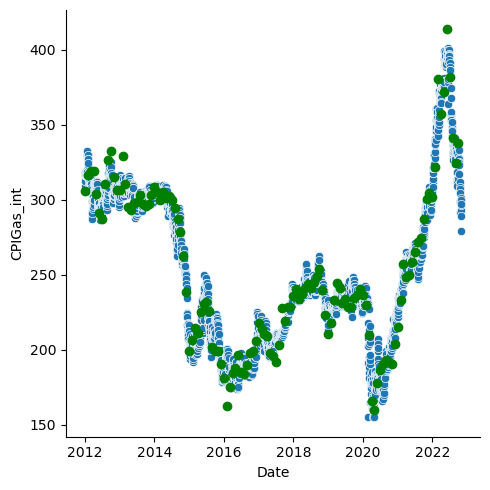

In [21]:
sns.relplot(data = daily_weekly_monthly, x = "Date", y = "CPIGas_int")
plt.scatter(monthly["Date"],monthly["CPIGas"], color="g")
plt.show()

In [22]:
all_df = pd.merge(daily_weekly_monthly["Date"], quarterly, on="Date", how = "outer").sort_values(by = "Date")
all_df = all_df.set_index(["Date"]).shift(1)
all_df.reset_index(inplace = True)
all_df = all_df.dropna()
all_df = pd.merge(all_df, daily_weekly_monthly, on = "Date", how = "outer").drop(["Mortgage30"], axis=1)

all_df["GDPCapita"] = (all_df["GDPCapita"] - np.mean(all_df["GDPCapita"]))/np.std(all_df["GDPCapita"])
all_df["PotentialGDP"] = (all_df["PotentialGDP"] - np.mean(all_df["PotentialGDP"]))/np.std(all_df["PotentialGDP"]) 
all_df["HouseholdDebt"] = (all_df["HouseholdDebt"] - np.mean(all_df["HouseholdDebt"]))/np.std(all_df["HouseholdDebt"])
all_df["GovtDebt"] = (all_df["GovtDebt"] - np.mean(all_df["GovtDebt"]))/np.std(all_df["GovtDebt"]) 

all_df_train = all_df.sort_values(by = "Date")
all_df_train = all_df_train.dropna()

all_df_train_pre = all_df_train.query("Date < '2020-03-01'")
all_df_train_post = all_df_train.query("Date >= '2020-03-01'")

daily_weekly_monthly_pre = daily_weekly_monthly.query("Date < '2020-03-01'")
daily_weekly_monthly_post = daily_weekly_monthly.query("Date >= '2020-03-01'")
quarterly_int_pre = pd.DataFrame()
quarterly_int_post = pd.DataFrame()
quarterly_variables = ["GDPCapita", "PotentialGDP", "HouseholdDebt", "GovtDebt"]

for i in range(len(quarterly_variables)):
    kernel_pre = WhiteKernel() + 1*RBF()
    gaussian_process_pre = GaussianProcessRegressor(kernel=kernel_pre, n_restarts_optimizer = 10)
    gaussian_process_pre.fit(all_df_train_pre.drop(["Date","GDPCapita", "PotentialGDP", "HouseholdDebt", "GovtDebt"],axis=1), 
                     all_df_train_pre[quarterly_variables[i]])
    kernel_post = WhiteKernel() + 1*RBF()
    gaussian_process_post = GaussianProcessRegressor(kernel=kernel_post, n_restarts_optimizer = 10)
    gaussian_process_post.fit(all_df_train_post.drop(["Date","GDPCapita", "PotentialGDP", "HouseholdDebt", "GovtDebt"],axis=1), 
                     all_df_train_post[quarterly_variables[i]])
    
    mean_prediction_pre, std_prediction_pre = gaussian_process_pre.predict(
        daily_weekly_monthly_pre.drop(["Date","Mortgage30"], axis = 1), return_std=True)
    mean_prediction_post, std_prediction_post = gaussian_process_post.predict(
        daily_weekly_monthly_post.drop(["Date", "Mortgage30"], axis = 1), return_std = True)
    quarterly_int_pre[quarterly_variables[i] + "_int"] = mean_prediction_pre
    quarterly_int_post[quarterly_variables[i] + "_int"] = mean_prediction_post

In [30]:
quarterly_int = pd.concat([quarterly_int_pre, quarterly_int_post]) 
quarterly_int = quarterly_int.reset_index(drop = True)
model_df = pd.concat([daily_weekly_monthly, quarterly_int], axis = 1)

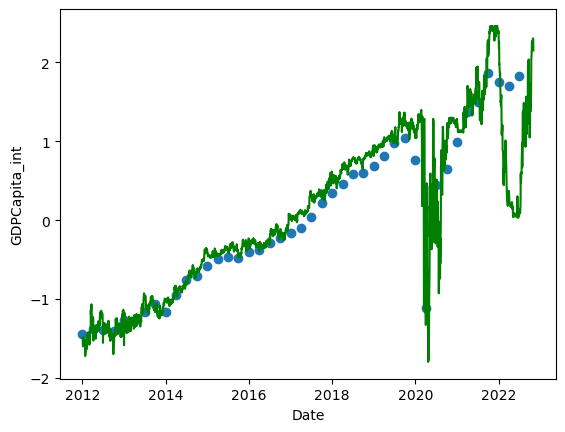

In [31]:
sns.lineplot(data = model_df, x = "Date",y = "GDPCapita_int", color="g")
plt.scatter(quarterly["Date"], quarterly["GDPCapita"])
plt.show()

In [32]:
tsla.stock["Prior_Close"] = tsla.stock.shift(1)["Close"]
Log_Daily_Return = np.log(tsla.stock["Close"]/tsla.stock["Prior_Close"])
tsla.stock["Log_Daily_Return"] = Log_Daily_Return
tsla.stock = tsla.stock.reset_index("Date")

aapl.stock["Prior_Close"] = aapl.stock.shift(1)["Close"] 
Log_Daily_Return = np.log(aapl.stock["Close"]/aapl.stock["Prior_Close"])
aapl.stock["Log_Daily_Return"] = Log_Daily_Return
aapl.stock = aapl.stock.reset_index("Date")

jpm.stock["Prior_Close"] = jpm.stock.shift(1)["Close"] 
Log_Daily_Return = np.log(jpm.stock["Close"]/jpm.stock["Prior_Close"])
jpm.stock["Log_Daily_Return"] = Log_Daily_Return
jpm.stock = jpm.stock.reset_index("Date")

amzn.stock["Prior_Close"] = amzn.stock.shift(1)["Close"] 
Log_Daily_Return = np.log(amzn.stock["Close"]/amzn.stock["Prior_Close"])
amzn.stock["Log_Daily_Return"] = Log_Daily_Return
amzn.stock = amzn.stock.reset_index("Date")

goog.stock["Prior_Close"] = goog.stock.shift(1)["Close"] 
Log_Daily_Return = np.log(goog.stock["Close"]/goog.stock["Prior_Close"])
goog.stock["Log_Daily_Return"] = Log_Daily_Return
goog.stock = goog.stock.reset_index("Date")

In [33]:
model_df = model_df.drop(["Mortgage30"], axis = 1)

values = model_df.drop(["Date"], axis = 1).iloc[1:].values
values2 = model_df.drop(["Date"], axis=1).shift(1).dropna().values

In [35]:
values = np.log((values)/(values2))
df = pd.DataFrame(values, columns = model_df.columns[1:15])
df["Date"] = model_df["Date"]
df = df.dropna()

C:\Users\Owner\AppData\Local\Temp\ipykernel_199380\1241353980.py:1: RuntimeWarning: divide by zero encountered in true_divide
  values = np.log((values)/(values2))
C:\Users\Owner\AppData\Local\Temp\ipykernel_199380\1241353980.py:1: RuntimeWarning: invalid value encountered in true_divide
  values = np.log((values)/(values2))
C:\Users\Owner\AppData\Local\Temp\ipykernel_199380\1241353980.py:1: RuntimeWarning: divide by zero encountered in log
  values = np.log((values)/(values2))
C:\Users\Owner\AppData\Local\Temp\ipykernel_199380\1241353980.py:1: RuntimeWarning: invalid value encountered in log
  values = np.log((values)/(values2))


In [36]:
tsla.stock = tsla.stock[20:tsla.stock.shape[0]]
aapl.stock = aapl.stock[20:aapl.stock.shape[0]]
jpm.stock = jpm.stock[20:jpm.stock.shape[0]]
amzn.stock = amzn.stock[20:amzn.stock.shape[0]]
goog.stock = goog.stock[20:goog.stock.shape[0]]

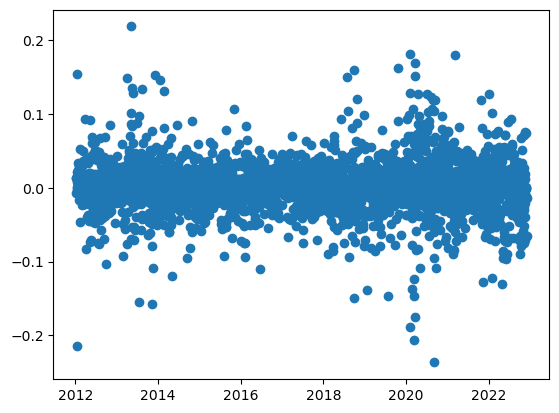

In [37]:
plt.scatter(tsla.stock["Date"], tsla.stock["Log_Daily_Return"])
plt.show()

In [328]:
Date = tsla.stock["Date"]
Tsla = tsla.stock["Log_Daily_Return"]
Aapl = aapl.stock["Log_Daily_Return"]
Jpm = jpm.stock["Log_Daily_Return"]
Amzn = amzn.stock["Log_Daily_Return"]
Goog = goog.stock["Log_Daily_Return"]
Tsla_price = tsla.stock["Open"]
Aapl_price = aapl.stock["Open"]
Jpm_price = jpm.stock["Open"]
Amzn_price = amzn.stock["Open"]
Goog_price = goog.stock["Open"]
Tsla_volume = tsla.stock["Volume"]
Aapl_volume = aapl.stock["Volume"]
Jpm_volume = jpm.stock["Volume"]
Amzn_volume = amzn.stock["Volume"]
Goog_volume = goog.stock["Volume"]


financial_data = {"Date":Date, "Tsla":Tsla, "Aapl": Aapl, "Jpm": Jpm, "Amzn": Amzn, "Goog":Goog, 
                  "Tsla_price": Tsla_price, "Aapl_price": Aapl_price, "Jpm_price": Jpm_price, "Amzn_price": Amzn_price, 
                  "Goog_price":Goog_price, "Tsla_volume": Tsla_volume, "Aapl_volume": Aapl_volume, "Jpm_volume": Jpm_volume, 
                  "Amzn_volume": Amzn_volume, "Goog_volume":Goog_volume}

financial_data = pd.DataFrame(financial_data)

## length of economic data is 2711, but 2749 for financial data
financial_data = financial_data.reset_index(drop=True)

financial_data = financial_data[0:2725]

financial_data["Date"] = pd.to_datetime(financial_data["Date"])

financial_data["Date"] = pd.to_datetime(financial_data["Date"]).dt.date

model_df["Date"] = pd.to_datetime(model_df["Date"]).dt.date

data = pd.merge(financial_data, model_df, on = "Date", how = "outer")

data = data.dropna()

data["Date"] = pd.to_datetime(data["Date"])

data_2012 = data.query("Date < '2013-01-01'")
data_2013 = data.query("Date < '2014-01-01' & Date >= '2013-01-01'")
data_2014 = data.query("Date < '2015-01-01' & Date >= '2014-01-01'")
data_2015 = data.query("Date < '2016-01-01' & Date >= '2015-01-01'")
data_2016 = data.query("Date < '2017-01-01' & Date >= '2016-01-01'")
data_2017 = data.query("Date < '2018-01-01' & Date >= '2017-01-01'")
data_2018 = data.query("Date < '2019-01-01' & Date >= '2018-01-01'")
data_2019 = data.query("Date < '2020-01-01' & Date >= '2019-01-01'")
data_2020 = data.query("Date < '2021-01-01' & Date >= '2020-01-01'")
data_2021 = data.query("Date < '2022-01-01' & Date >= '2021-01-01'")
data_2022 = data.query("Date < '2023-01-01' & Date >= '2022-01-01'")

In [329]:
df["Date"] = pd.to_datetime(model_df["Date"]).dt.date
data2 = pd.merge(financial_data, df, on = "Date", how = "outer")
data2 = data2.dropna()
data2["Date"] = pd.to_datetime(data2["Date"])

In [80]:
mean = []
for i in data.columns[1:6]:
    column = data[i]
    value = np.round(np.mean(column),4)
    mean.append(value)
    
import powerlaw


alpha = []
financial_data = financial_data.dropna()
for i in data.columns[1:6]:
    column = np.abs(data[i])
    fitted = powerlaw.Fit(column, verbose = 0)
    fitted.alpha = np.round(fitted.alpha,2)
    alpha.append(fitted.alpha)

In [77]:
alpha

[3.2, 4.03, 3.83, 3.62, 3.96]

In [206]:
def auto_correlation(x,lag = 1):
    a = pd.Series(np.reshape(x,(-1)))
    b = a.autocorr(lag = lag)
    if np.isnan(b) or np.isinf(b):
        return 0
    return b

def acf(x,max_lag=200):
    acf = []
    for i in range(max_lag):
        acf.append(auto_correlation(x,lag=i+1))
    return np.array(acf)

def acf_abs(x,max_lag=200):
    x = np.abs(x)
    acf = []
    for i in range(max_lag):
        acf.append(auto_correlation(x,lag=i+1))
    return np.array(acf)

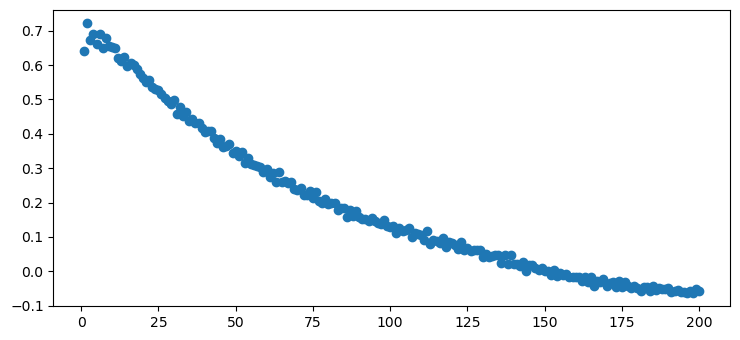

In [325]:
x = list(range(1,201))
y = acf_abs(generated_data["Jpm"])
plt.scatter(x,y)
plt.show()

In [145]:
np.corrcoef(data["Jpm_price"], data["Unemployment_int"])

array([[ 1.        , -0.42898082],
       [-0.42898082,  1.        ]])

In [146]:
np.corrcoef(data2["Tsla"], data2["TBond30"])

array([[ 1.        , -0.02603856],
       [-0.02603856,  1.        ]])

In [47]:
from keras.models import Sequential
from keras.layers import Add
from keras.optimizers import Adam,Nadam
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, Reshape,Flatten, Dropout, Lambda, RepeatVector
from keras.layers import Add,Multiply
from keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Convolution1D
from keras.layers import LeakyReLU
from keras.optimizers import Adam,Nadam
from keras.utils import plot_model
#from keras.utils.training_utils import multi_gpu_model
from keras import backend as K
import random
import keras

In [48]:
def MinMaxScaler(data):
    """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return norm_data

In [49]:
def real_data_loading(data,seq_len):
    ori_data = data
    temp_data = []    
    for i in range(0, 10):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)
    idx = np.random.permutation(len(temp_data))    
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data


In [50]:
data = data.reset_index(drop=True)
X_train = data.iloc[0:2496,6:30].values
y_train = data.iloc[0:2496,1:6].values
X_test = data.iloc[2496:2705,6:30].values
y_test = data.iloc[2496:2705,1:6].values

In [51]:
def extract_time(data):
    time = list()
    max_seq_len = 0
    for i in range(len(data)):
        max_seq_len = max(max_seq_len, len(data[i][:,0]))
        time.append(len(data[i][:,0]))
    
    return time, max_seq_len

def rnn_cell(module_name, hidden_dim):
    if (module_name == 'gru'):
        rnn_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
    
    return rnn_cell


def random_generator(batch_size, z_dim, T_mb, max_seq_len):
    Z_mb = list()
    for i in range(batch_size):
        temp = np.zeros([max_seq_len, z_dim])
        temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
        temp[:T_mb[i],:] = temp_Z
        Z_mb.append(temp_Z)
    return Z_mb


def batch_generator(data, time, batch_size):
    no = len(data)
    idx = np.random.permutation(no)
    train_idx = idx[:batch_size]     
    X_mb = list(data[i] for i in train_idx)
    T_mb = list(time[i] for i in train_idx)
    return X_mb, T_mb

In [52]:
from tf_slim.layers import layers as _layers

In [331]:
def timegan (ori_data, parameters):
    tf.reset_default_graph()
    no, seq_len, dim = np.asarray(ori_data).shape
    ori_time, max_seq_len = extract_time(ori_data)
    def MinMaxScaler(data):   
        min_val = np.min(np.min(data, axis = 0), axis = 0)
        data = data - min_val 
        max_val = np.max(np.max(data, axis = 0), axis = 0)
        norm_data = data / (max_val + 1e-7) 
        return norm_data, min_val, max_val
    
    ori_data, min_val, max_val = MinMaxScaler(ori_data)
              
    hidden_dim   = parameters['hidden_dim'] 
    num_layers   = parameters['num_layer']
    iterations   = parameters['iterations']
    batch_size   = parameters['batch_size']
    module_name  = parameters['module'] 
    z_dim        = dim
    gamma        = 1
    
    tf.compat.v1.disable_eager_execution() 
    
    X = tf.compat.v1.placeholder(tf.float32, [None, max_seq_len, dim], name = "myinput_x")
    Z = tf.compat.v1.placeholder(tf.float32, [None, max_seq_len, z_dim], name = "myinput_z")
    T = tf.compat.v1.placeholder(tf.int32, [None], name = "myinput_t")
  
    def embedder (X, T):
        with tf.variable_scope("embedder", reuse = tf.AUTO_REUSE):
            e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, X, dtype=tf.float32, sequence_length = T)
            H = _layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
        return H
      
    def recovery (H, T):       
        with tf.variable_scope("recovery", reuse = tf.AUTO_REUSE):  
            print(H)
            r_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
            r_outputs, r_last_states = tf.nn.dynamic_rnn(r_cell, H, dtype=tf.float32, sequence_length = T)
            X_tilde = _layers.fully_connected(r_outputs, dim, activation_fn=tf.nn.sigmoid) 
        return X_tilde
    
    def generator (Z, T):  
        with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
            e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, Z, dtype=tf.float32, sequence_length = T)
            E = _layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
        return E
      
    def supervisor (H, T): 
        with tf.variable_scope("supervisor", reuse = tf.AUTO_REUSE):
            e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers-1)])
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, H, dtype=tf.float32, sequence_length = T)
            S = _layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
        return S
          
    def discriminator (H, T):       
        with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
            d_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, H, dtype=tf.float32, sequence_length = T)
            Y_hat = _layers.fully_connected(d_outputs, 1, activation_fn=None) 
        return Y_hat   
    
    H = embedder(X, T)
    X_tilde = recovery(H, T)
    
    E_hat = generator(Z, T)
    H_hat = supervisor(E_hat, T)
    H_hat_supervise = supervisor(H, T)
    
    X_hat = recovery(H_hat, T)
    
    Y_fake = discriminator(H_hat, T)
    Y_real = discriminator(H, T)     
    Y_fake_e = discriminator(E_hat, T)
    
        
    e_vars = [v for v in tf.trainable_variables() if v.name.startswith('embedder')]
    r_vars = [v for v in tf.trainable_variables() if v.name.startswith('recovery')]
    g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
    s_vars = [v for v in tf.trainable_variables() if v.name.startswith('supervisor')]
    d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
  
    D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_real), Y_real)
    D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake), Y_fake)
    D_loss_fake_e = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake_e), Y_fake_e)
    D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e
            
    G_loss_U = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake), Y_fake)
    G_loss_U_e = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake_e), Y_fake_e)
    
 
    G_loss_S = tf.losses.mean_squared_error(H[:,1:,:], H_hat_supervise[:,:-1,:])
    
  
    G_loss_V1 = tf.reduce_mean(tf.abs(tf.sqrt(tf.nn.moments(X_hat,[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(X,[0])[1] + 1e-6)))
    G_loss_V2 = tf.reduce_mean(tf.abs((tf.nn.moments(X_hat,[0])[0]) - (tf.nn.moments(X,[0])[0])))
    
    G_loss_V = G_loss_V1 + G_loss_V2
    
    G_loss = G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100*G_loss_V 
            

    E_loss_T0 = tf.losses.mean_squared_error(X, X_tilde)
    E_loss0 = 10*tf.sqrt(E_loss_T0)
    E_loss = E_loss0  + 0.1*G_loss_S
    
    E0_solver = tf.train.AdamOptimizer().minimize(E_loss0, var_list = e_vars + r_vars)
    E_solver = tf.train.AdamOptimizer().minimize(E_loss, var_list = e_vars + r_vars)
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = g_vars + s_vars)      
    GS_solver = tf.train.AdamOptimizer().minimize(G_loss_S, var_list = g_vars + s_vars)   
        
     
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
  
    print('Start Embedding Network Training')
    
    for itt in range(iterations):
        X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)           
        _, step_e_loss = sess.run([E0_solver, E_loss_T0], feed_dict={X: X_mb, T: T_mb})        
        if itt % 100 == 0:
            print('step: '+ str(itt) + '/' + str(iterations) + ', e_loss: ' + str(np.round(np.sqrt(step_e_loss),4)) ) 
      
    print('Finish Embedding Network Training')
    
 
    print('Start Training with Supervised Loss Only')
    
    for itt in range(iterations):
        X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)      
        Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
        _, step_g_loss_s = sess.run([GS_solver, G_loss_S], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})       
        if itt % 100 == 0:
            print('step: '+ str(itt)  + '/' + str(iterations) +', s_loss: ' + str(np.round(np.sqrt(step_g_loss_s),4)) )
      
    print('Finish Training with Supervised Loss Only')
    
    print('Start Joint Training')
  
    for itt in range(iterations):
        for kk in range(2):
            X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)               
            Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
            _, step_g_loss_u, step_g_loss_s, step_g_loss_v = sess.run(
                [G_solver, G_loss_U, G_loss_S, G_loss_V], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
            _, step_e_loss_t0 = sess.run([E_solver, E_loss_T0], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})   
           
   
            X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)           
            Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
            check_d_loss = sess.run(D_loss, feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
            if (check_d_loss > 0.15):        
                _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
    
            if itt % 50 == 0:
               print('step: '+ str(itt) + '/' + str(iterations) + 
                     ', d_loss: ' + str(np.round(step_d_loss,4)) + 
                     ', g_loss_u: ' + str(np.round(step_g_loss_u,4)) + 
                     ', g_loss_s: ' + str(np.round(np.sqrt(step_g_loss_s),4)) + 
                     ', g_loss_v: ' + str(np.round(step_g_loss_v,4)) + 
                     ', e_loss_t0: ' + str(np.round(np.sqrt(step_e_loss_t0),4))  )
    
    print('Finish Joint Training')
    
     
    Z_mb = random_generator(no, z_dim, ori_time, max_seq_len)
    generated_data_curr = sess.run(X_hat, feed_dict={Z: Z_mb, X: ori_data, T: ori_time})    
    
    generated_data = list()
    
    for i in range(5*no):
        temp = generated_data_curr[i,:ori_time[i],:]
        generated_data.append(temp)
        
    generated_data = generated_data * max_val
    generated_data = generated_data + min_val
    
    return generated_data

In [156]:
import warnings
warnings.filterwarnings("ignore")

ori_data = real_data_loading(data.iloc[0:2496,1:25].values,50)

In [332]:
ori_data = []
ori_data.append(data_2012.drop(["Date"],axis=1).values)
ori_data.append(data_2013.drop(["Date"],axis=1).values)
ori_data.append(data_2014.drop(["Date"],axis=1).values)
ori_data.append(data_2015.drop(["Date"],axis=1).values)
ori_data.append(data_2016.drop(["Date"],axis=1).values)
ori_data.append(data_2017.drop(["Date"],axis=1).values)
ori_data.append(data_2018.drop(["Date"],axis=1).values)
ori_data.append(data_2019.drop(["Date"],axis=1).values)
ori_data.append(data_2020.drop(["Date"],axis=1).values)
ori_data.append(data_2021.drop(["Date"],axis=1).values)

In [333]:
for i in range(10):
    ori_data[i] = ori_data[i][0:245,:]


In [163]:
warnings.filterwarnings("ignore")
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()

In [1]:
warnings.filterwarnings("ignore")
parameters = dict()  
parameters['module'] = 'gru'
parameters['hidden_dim'] = 50
parameters['num_layer'] = 2
parameters['iterations'] = 2000
parameters['batch_size'] = 3
      
generated_data = timegan(ori_data, parameters)    

NameError: name 'warnings' is not defined

In [335]:
generated_data2 = generated_data
generated_data = generated_data.reshape((-1,24))

generated_data = pd.DataFrame(generated_data)

generated_data.columns = data.columns[1:25]

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [342]:
generated_data.to_csv(r'C:/Users/Owner/Documents/generated_data_GAN.csv')

In [337]:
generated_data.shape

(2450, 24)

In [238]:
X_train = pd.concat([data_2012[0:245],data_2013[0:245],data_2014[0:245],data_2015[0:245],data_2016[0:245], 
                     data_2017[0:245],data_2018[0:245],data_2019[0:245],data_2020[0:245],data_2021[0:245] ],axis=0)

In [272]:
np.corrcoef(generated_data["Jpm_price"], generated_data["TBond30"])

array([[1.        , 0.56513065],
       [0.56513065, 1.        ]])

In [280]:
bond_corr = []
gen_bond_corr = []
for i in range(5):
    bond_corr.append(np.corrcoef(X_train.iloc[:,i+5],X_train["TBond30"])[1,0])
    gen_bond_corr.append(np.corrcoef(generated_data.iloc[:,i+4],generated_data["TBond30"])[1,0])
                   
unemploy_corr = []
gen_unemploy_corr = []
for i in range(5):
    unemploy_corr.append(np.corrcoef(X_train.iloc[:,i+5],X_train["Unemployment_int"])[1,0])
    gen_unemploy_corr.append(np.corrcoef(generated_data.iloc[:,i+4],generated_data["Unemployment_int"])[1,0])
    
gdp_corr = []
gen_gdp_corr = []
for i in range(5):
    gdp_corr.append(np.corrcoef(X_train.iloc[:,i+5],X_train["GDPCapita_int"])[1,0])
    gen_gdp_corr.append(np.corrcoef(generated_data.iloc[:,i+4],generated_data["GDPCapita_int"])[1,0])
    

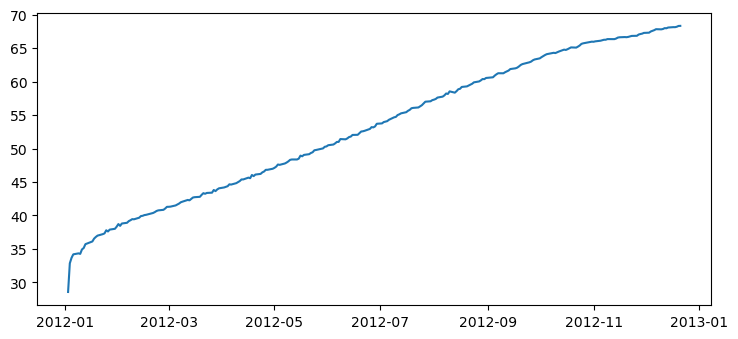

In [276]:
plt.plot(daily["Date"][0:245],generated_data.iloc[0:245,6])
plt.show()

In [277]:
gen_mean = []
for i in generated_data.columns[0:5]:
    column = generated_data[i]
    value = np.round(np.mean(column),4)
    gen_mean.append(value)

mean = []
for i in X_train.columns[1:6]:
    column = X_train[i]
    value = np.round(np.mean(column),4)
    mean.append(value)
    

In [279]:
table_df = pd.DataFrame([mean, gen_mean, alpha, gen_alpha, bond_corr,gen_bond_corr,
                         unemploy_corr,gen_unemploy_corr,gdp_corr,gen_gdp_corr], columns = generated_data.columns[0:5])
table_df

,Tsla,Aapl,Jpm,Amzn,Goog
0,0.002000,0.001100,0.000700,0.001100,0.000900
1,-0.002400,-0.004200,-0.004700,0.000600,-0.002700
2,3.220000,3.980000,3.740000,3.520000,3.800000
3,4.110000,9.090000,1.940000,2.450000,5.340000
4,-0.006129,-0.570659,-0.719329,-0.555394,-0.720023
5,0.093474,0.567045,0.440488,0.565131,0.550004
6,0.016874,-0.016378,-0.041258,-0.363758,-0.089698
7,0.242222,-0.943866,-0.882979,-0.959000,-0.948461
8,0.011387,0.659977,0.797839,0.944668,0.858678
9,-0.287698,0.947001,0.917909,0.980322,0.976439


In [278]:
gen_alpha = []
for i in range(5):
    column = np.abs(generated_data.iloc[:,i])
    fitted = powerlaw.Fit(column, verbose = 0)
    fitted.alpha = np.round(fitted.alpha,2)
    gen_alpha.append(fitted.alpha)
    
alpha = []
for i in range(5):
    column = np.abs(X_train.iloc[:,i+1])
    fitted = powerlaw.Fit(column, verbose = 0)
    fitted.alpha = np.round(fitted.alpha,2)
    alpha.append(fitted.alpha)
    

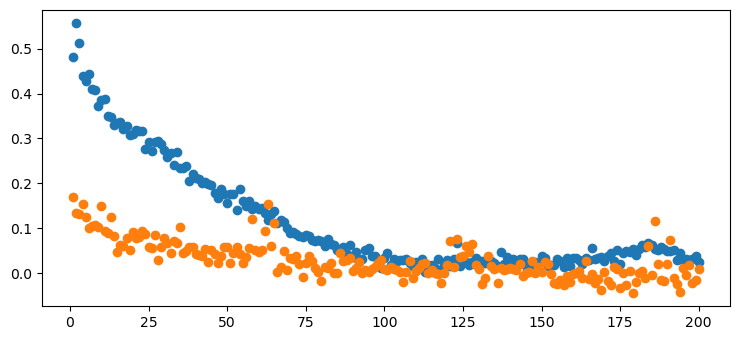

In [287]:
x = list(range(1,201))
y = acf_abs(generated_data.iloc[:,3])
z = acf_abs(data.iloc[:,4])
plt.scatter(x,y)
plt.scatter(x,z)
plt.show()

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [317]:
model_gru = Sequential()
model_gru.add(keras.layers.GRU(245, return_sequences=True,input_shape=
                               (train.shape[1], train.shape[2])))
model_gru.add(keras.layers.GRU(units=150, return_sequences=True))
model_gru.add(keras.layers.GRU(units=100))
model_gru.add(keras.layers.Dense(units=5))
model_gru.compile(loss='mae', optimizer='adam')

In [318]:
iters = 2000
batch_size = 2
for iters in range(iters):
    for batch in range(batch_size):
        sample = random.choice(list(range(10)))
        data = ori_data[sample]
        train = data[:,5:24]
        target = data[:,0:5]
        train = train.reshape((train.shape[0],1,train.shape[1]))
        target = target.reshape((target.shape[0],1,target.shape[1]))
        model_gru.train_on_batch(train,target)

InvalidArgumentError: data[0].shape = [3] does not start with indices[0].shape = [2]
	 [[{{node training_2/Adam/gradients/gradients/loss_3/dense_3_loss/Mean_grad/DynamicStitch}}]]

In [204]:
model_gru.compile(
    loss="mae",
    optimizer="adam"
)
gru_history = model_gru.fit(X_train, y_train, epochs = 250, batch_size=245, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/250
10/10 [==============================] - 6s 100ms/step - loss: 0.1274 - val_loss: 0.1412
Epoch 2/250
10/10 [==============================] - 0s 13ms/step - loss: 0.1446 - val_loss: 0.2499
Epoch 3/250
10/10 [==============================] - 0s 13ms/step - loss: 0.1633 - val_loss: 0.0936
Epoch 4/250
10/10 [==============================] - 0s 18ms/step - loss: 0.1214 - val_loss: 0.1210
Epoch 5/250
10/10 [==============================] - 0s 19ms/step - loss: 0.0977 - val_loss: 0.1007
Epoch 6/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0466 - val_loss: 0.0649
Epoch 7/250
10/10 [==============================] - 0s 17ms/step - loss: 0.0720 - val_loss: 0.0615
Epoch 8/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0558 - val_loss: 0.0604
Epoch 9/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0567 - val_loss: 0.0293
Epoch 10/250
10/10 [==============================] - 0s 17ms/step - loss: 0.0497 - val_loss: 0.049

In [ ]:
gru_history = model_gru.fit(X_train, y_train, epochs = 250, batch_size = 252, 
                            validation_data=(X_test, y_test), shuffle=False)

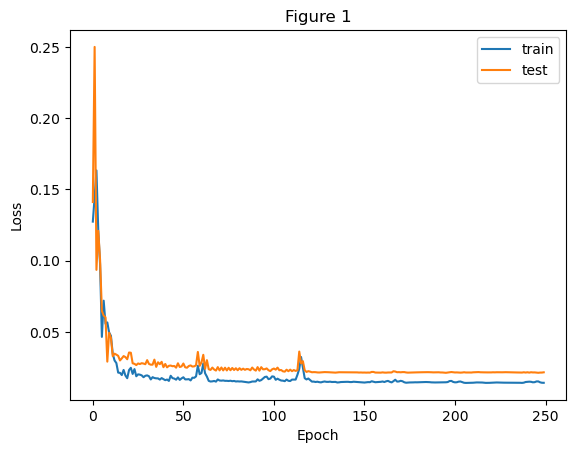

In [205]:
plt.plot(gru_history.history['loss'], label='train')
plt.plot(gru_history.history['val_loss'], label='test')
plt.title("Figure 1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

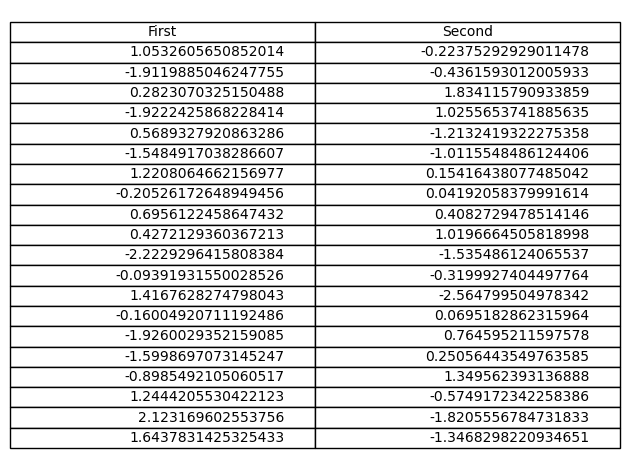

In [338]:
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#create data
f = pd.DataFrame(np.random.randn(20, 2), columns=['First', 'Second'])

#create table
table = ax.table(cellText=f.values, colLabels=f.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

### Results

### Conclusions
An obvious extension to our work would be to collect much more data on all fronts. For simplicity, we used only five stocks for the past 11 years along with 14 economic indicators. Vastly expanding the timeframe, number of stocks, and number of economic indicators would allow better stabilize the learning process and allow us to fit even more flexible models. In addition, we used the generated data as part of a regression problem. For practical purposes, we would like to have some measure of uncertainty in our predictions. Outputting a single number for the predicted stock return provides minimal value. Consequently, to do density estimation in some sense, we could discretize the distribution of log daily returns. We could then treat this as a multi-class classification problem and compare the two outputted vectors of probabilties by using the Kullback-Leibler divergence $D_{KL}(p||q) = \sum_{k=1}^{n}p_k\log(\frac{p_k}{q_k})$. Lastly, it would be interesting to apply reinforcement learning to determine how best to utilize the given predictions to maximize portfolio returns.

### References 
Koshiyama, N. Firoozye, P. Treleaven, Generative Adversarial Networks for Financial Trading Strategies Fine-Tuning and Combination, arXiv preprint arXiv:1901.01751, 2019.

Takahashi, S. Chen, Y. Tanaka-Ishii K. Modeling Financial Time Series with Generative Adversarial Networks. Physica A 527 (2019).

Salimans Tim, Goodfellow Ian, Zaremba Wojciech, Cheung Vicki, Radford Alec, and Chen Xi. 2016. Improved techniques for training GANs. In Advances in Neural Information Processing Systems. 2234–2242. 

Yujia Li, Kevin Swersky, and Richard Zemel. Generative moment matching networks. 10 February 2015.

Fekri MN, Ghosh AM, Grolinger K. Generating Energy Data for Machine Learning with Recurrent Generative Adversarial Networks. Energies. 2020; 13(1):130.

Cristóbal Esteban, Stephanie L Hyland, and Gunnar Rätsch. 2017. Real-valued
(medical) time series generation with recurrent conditional GANs. arXiv preprint
arXiv:1706.02633 (2017).

Homanga Bharadhwaj, Homin Park, and Brian Y. Lim. 2018. RecGAN: recurrent generative adversarial networks for recommendation systems. In Proceedings of the 12th ACM Conference on Recommender Systems. 372-376.

Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

### Appendix
For general economic indicators, the following were used:

Effective Federal Funds Rate: the rate banks charge each other for overnight loans to meet deposit requirments, serves as a measure of policy action by the Federal Reserve

3 Month Treasury Bill Rate and 1 Year Treasury Bill Rate: prevailing yield of 3 month and 1 year Treasury bonds; serves as a measure of short term interest rates

5 and 10 Year Treasury Bond Rates: prevailing yield of 5 year and 10 year Treasury bonds; serves as a measure of intermediate term interest rates

30 Year Treasury Bond Rate: prevailing yield of 30 year Treasury bonds; serves as ameasure of long term interest rates

30 Year Mortgage Rate: prevailing average interest rate for a 30 year fixed rate mortgage; measure of long term interest rates as well as quantitative easing for the Federal Reserve and overall health of the housing market 

Real GDP Per Capita: total economic output divided by the midyear population in terms of chained 2012 dollars; serves as a measure of the economic cycle and overall health of the economy

Unemployment Rate: number of people employed divided by the number of people in the labor force; serves as an additional measure of the economic cycle and overall health of the economy

Consumer Price Index: price of a basket of goods and services; serves as a measure of inflation

Consumer Price Index for Gas: price level of gasoline and related products; serves as a measure of inflation as well as a proxy for foreign policy relations

Real Potential GDP: total potential economic capacity; serves as a measure of technological improvement and capital accumulation

Public Debt as Percent of GDP: ratio of total outstanding government debt to GDP; captures the spending and taxing policies employed  by the federal government

Household Debt as Percent of GDP: ratio of total outstanding household debt to GDP; measures the borrowing habits of consumers and serves as a proxy for consumer confidence and the credit cycle